In [1]:
# import library
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
import matplotlib.pyplot as plt
#from sklearn import datasets
import warnings
from datetime import datetime
from datetime import date
warnings.filterwarnings("ignore")

     

In [2]:

# Load data from github
# File customer
url1 = 'https://raw.githubusercontent.com/syo2000/Workforce-Data-Dashboard-Partner-Sites-Report/refs/heads/main/Data/Data%20employee.csv'
tempHCEM = pd.read_csv(url1)
tempHCEM.head()

,EmployeeID,First_Name,Surname,StreetAddress,City,State,StateFull,ZipCode,Country,CountryFull,...,Voluntary/ Involuntary,Office_Type,Department,Currency,Bonus_pct,Job_title,DOB,level,Salary,Active Status
0,100001,Patrice,Moore,1427 Buckhannan Avenue,North Syracuse,NY,New York,13212.0,US,United States,...,NaN,Corporate,Corporate,USD,1.00,CEO,31417,CSuite,500000,1
1,100002,David,Rickards,4265 Graystone Lakes,Macon,GA,Georgia,31206.0,US,United States,...,NaN,Corporate,Corporate,USD,0.20,HR Manager,26127,Manager,70000,1
2,100003,Grace,Maldonado,1680 Hudson Street,Weehawken,NJ,New Jersey,7087.0,US,United States,...,Involuntary,Corporate,Marketing,USD,0.15,Graphic Designer,32533,Individual Contributor,77000,0
3,100004,Justin,Edgin,1262 Limer Street,Rome,GA,Georgia,30165.0,US,United States,...,Involuntary,Corporate,Technology,USD,0.50,CTO,35186,CSuite,400000,0
4,100005,Benjamin,Vargas,2431 Rainbow Road,Santa Ana,CA,California,92705.0,US,United States,...,Voluntary,Corporate,Customer Service,USD,0.15,Associate Account Manager,26424,Manager,51000,0


In [3]:
# Tạo tmpDIMDATE từ năm 2009 đến hiện tại
start_date = '2009-01-01'
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

tmpDIMDATE = pd.DataFrame({'FullDate': pd.date_range(start=start_date, end=end_date, freq='M')})
tmpDIMDATE['FirstDayOfMonth'] = tmpDIMDATE['FullDate'].dt.to_period('M').dt.start_time
tmpDIMDATE['LastDayOfMonth'] = tmpDIMDATE['FullDate'].dt.to_period('M').dt.end_time
tmpDIMDATE['YearMonth'] = tmpDIMDATE['FullDate'].dt.to_period('M').astype(str)

# Chuyển đổi Start_Date và Termination_Date
tempHCEM['StartDate'] = pd.to_datetime(tempHCEM['Start_Date'], format='%d/%m/%Y', errors='coerce')
tempHCEM['EndDate'] = pd.to_datetime(tempHCEM['Termination_Date'], format='%d/%m/%Y', errors='coerce')

# Tạo bảng convert_data
convert_data = pd.merge(tempHCEM, tmpDIMDATE, how='cross')
convert_data['FirstOfLastMonth'] = (pd.to_datetime(convert_data['YearMonth']) - pd.offsets.MonthBegin(1))
convert_data['LastOfLastMonth'] = (pd.to_datetime(convert_data['YearMonth']) - pd.offsets.MonthEnd(1))

convert_data['In'] = np.where(
    (convert_data['StartDate'].dt.strftime('%Y-%m') >= convert_data['FirstDayOfMonth'].dt.strftime('%Y-%m')) &
    (convert_data['StartDate'].dt.strftime('%Y-%m') <= convert_data['LastDayOfMonth'].dt.strftime('%Y-%m')),
    1, 0
)

convert_data['Out'] = np.where(
    (convert_data['EndDate'].dt.strftime('%Y-%m') >= convert_data['FirstDayOfMonth'].dt.strftime('%Y-%m')) &
    (convert_data['EndDate'].dt.strftime('%Y-%m') <= convert_data['LastDayOfMonth'].dt.strftime('%Y-%m')),
    1, 0
)

# Tính toán HC1
convert_data['HC1'] = np.where(
    (convert_data['StartDate'] > convert_data['EndDate']) &
    (convert_data['StartDate'] <= convert_data['LastOfLastMonth']) &
    (convert_data['EndDate'] > convert_data['LastOfLastMonth']),
    1,
    np.where(
        (convert_data['StartDate'] <= convert_data['LastOfLastMonth']) &
        ((convert_data['EndDate'] >= convert_data['FirstDayOfMonth']) | convert_data['EndDate'].isnull()),
        1, 0
    )
)

# Tổng hợp dữ liệu
grouped = convert_data.groupby('YearMonth').agg(
    HC1=('HC1', 'sum'),
    In=('In', 'sum'),
    Out=('Out', 'sum')
).reset_index()

grouped['HC2'] = grouped['HC1'] - grouped['In'] - grouped['Out']

# Sắp xếp và hiển thị kết quả
result = grouped.sort_values('YearMonth')


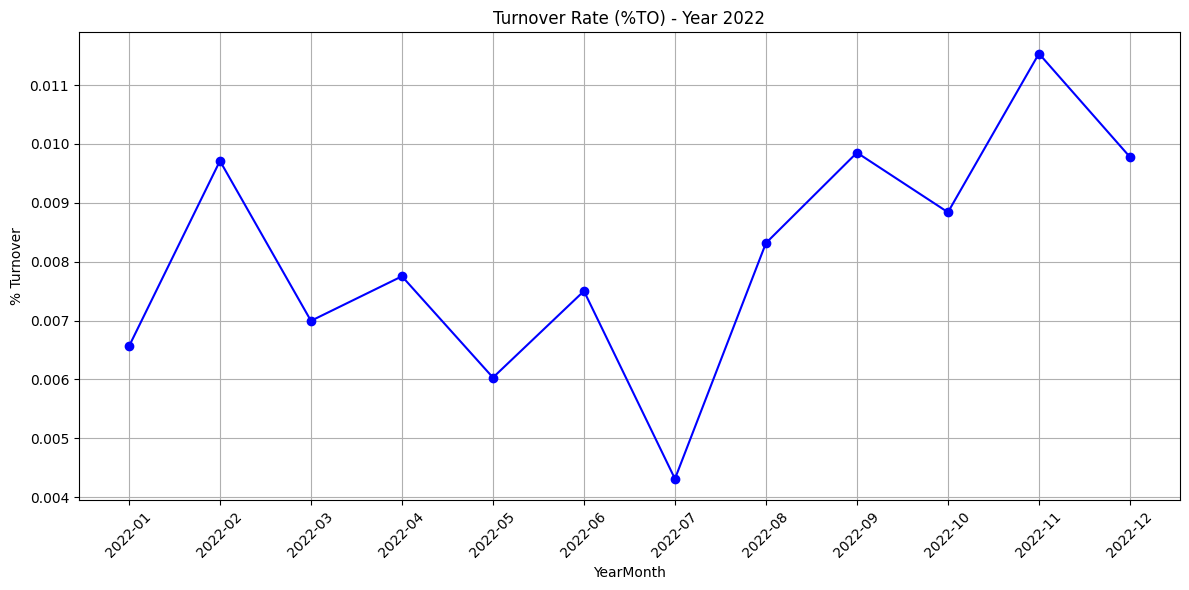

    YearMonth   HC1  In  Out   HC2       %TO
156   2022-01  2909   7   19  2883  0.006561
157   2022-02  2897   0   28  2869  0.009712
158   2022-03  2869   0   20  2849  0.006995
159   2022-04  2849   0   22  2827  0.007752
160   2022-05  2827   0   17  2810  0.006032
161   2022-06  2810   0   21  2789  0.007501
162   2022-07  2789   0   12  2777  0.004312
163   2022-08  2777   0   23  2754  0.008317
164   2022-09  2754   0   27  2727  0.009852
165   2022-10  2727   0   24  2703  0.008840
166   2022-11  2703   0   31  2672  0.011535
167   2022-12  2672   0   26  2646  0.009778


In [6]:
# Lọc dữ liệu cho năm 2022
grouped['%TO'] = grouped['Out'] / ((grouped['HC1'] + grouped['HC2']) / 2)
grouped['YearMonth'] = pd.to_datetime(grouped['YearMonth'])
grouped_2022 = grouped[grouped['YearMonth'].dt.year == 2022]

# Chuyển YearMonth thành yyyy-mm (lưu ý chỉ chuyển khi cần thiết)
grouped_2022['YearMonth'] = grouped_2022['YearMonth'].dt.strftime('%Y-%m')

# Vẽ biểu đồ %TO cho năm 2022
plt.figure(figsize=(12, 6))
plt.plot(grouped_2022['YearMonth'], grouped_2022['%TO'], marker='o', linestyle='-', color='b')
plt.title('Turnover Rate (%TO) - Year 2022')
plt.xlabel('YearMonth')
plt.ylabel('% Turnover')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Hiển thị dữ liệu năm 2022
print(grouped_2022)
